In [41]:
# test_phase_5a_dimensionality.ipynb

import numpy as np
import pandas as pd
from neural_mi.data.processors import ContinuousProcessor
from neural_mi.analysis.dimensionality import run_dimensionality_analysis

if __name__ == '__main__':
    print(f"--- Testing Phase 5a: The Dimensionality Engine ---")
    device = 'cpu'

    # 1. Generate data with a known low-dimensional structure
    N_SAMPLES = 50000
    N_CHANNELS = 50 # A population of 20 neurons
    LATENT_DIM = 7   # The ground truth dimensionality we want to recover
    
    # Create a low-dimensional latent signal
    latent_signal = np.random.randn(LATENT_DIM, N_SAMPLES)
    # Project it up to the high-dimensional neural space
    projection_matrix = np.random.randn(N_CHANNELS, LATENT_DIM)
    x_raw = projection_matrix @ latent_signal + np.random.randn(N_CHANNELS, N_SAMPLES) * 0.1
    
    cont_proc = ContinuousProcessor(window_size=100, step_size=50)
    x_data = cont_proc.process(x_raw).to(device)
    print(f"Created data with known latent dim={LATENT_DIM}, shape={x_data.shape}")
    print("-" * 40)
    
    # 2. Define Parameters for the analysis
    base_params = {
        'hidden_dim': 128, 'n_layers': 3, 'learning_rate': 1e-4,
        'n_epochs': 100, 'batch_size': 128, 'patience': 20
    }

    # We want to sweep over embedding dimensions to find the saturation point
    sweep_grid = {
        'embedding_dim': range(1,11),
    }
    
    # 3. Run the dimensionality analysis
    # Use a small n_splits for a quick test
    summary_df = run_dimensionality_analysis(
        x_data=x_data,
        base_params=base_params,
        sweep_grid=sweep_grid,
        n_splits=20, 
        n_workers=6
    )
    
    # 4. Verification
    print("\n--- Verification ---")
    print("Dimensionality Analysis Results:")
    print(summary_df)
    
    assert 'embedding_dim' in summary_df.columns
    assert 'mi_mean' in summary_df.columns
    assert 'mi_std' in summary_df.columns
    assert len(summary_df) == len(sweep_grid['embedding_dim'])
    
    # Check for the expected saturation pattern
    # The MI should increase and then start to plateau around the true latent_dim
    # mi_at_latent_dim = summary_df[summary_df['embedding_dim'] == LATENT_DIM]['mi_mean'].iloc[0]
    # mi_at_double_latent_dim = summary_df[summary_df['embedding_dim'] == LATENT_DIM * 2]['mi_mean'].iloc[0]
    
    # We expect the jump after the true dimension to be smaller
    # Note: This is a stochastic test, but should generally hold
    # print(f"\nMI at true dim ({LATENT_DIM}): {mi_at_latent_dim:.4f}")
    # print(f"MI at 2*true dim ({LATENT_DIM*2}): {mi_at_double_latent_dim:.4f}")

    print("\n✅ Phase 5a (Dimensionality) test completed successfully!")

--- Testing Phase 5a: The Dimensionality Engine ---
Created data with known latent dim=7, shape=torch.Size([999, 50, 100])
----------------------------------------

--- Running Split 1/20 ---
Starting parameter sweep with 6 workers...
Created 10 tasks for the sweep...
Epoch 1/100 | Test MI: -0.0350
Epoch 2/100 | Test MI: -0.0230
Epoch 3/100 | Test MI: -0.0282
Epoch 4/100 | Test MI: -0.0481
Epoch 5/100 | Test MI: -0.1079
Epoch 6/100 | Test MI: -0.1321
Epoch 7/100 | Test MI: -0.1177
Epoch 8/100 | Test MI: -0.0991
Epoch 9/100 | Test MI: -0.0846
Epoch 10/100 | Test MI: -0.0922
Epoch 11/100 | Test MI: -0.0855
Epoch 12/100 | Test MI: -0.0627
Epoch 13/100 | Test MI: -0.0599
Epoch 14/100 | Test MI: -0.0728
Epoch 15/100 | Test MI: -0.0684
Epoch 16/100 | Test MI: -0.0585
Epoch 17/100 | Test MI: -0.0686
Epoch 18/100 | Test MI: -0.0769
Epoch 19/100 | Test MI: -0.0644
Epoch 20/100 | Test MI: -0.0695
Epoch 21/100 | Test MI: -0.0622
Epoch 22/100 | Test MI: -0.0537
Early stopping triggered after 20 ep

(-0.1, 0.5)

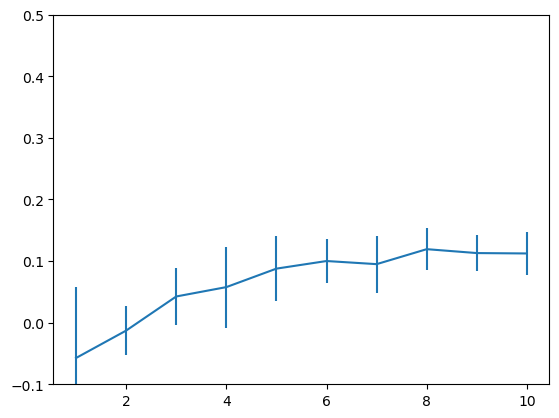

In [43]:
import matplotlib.pyplot as plt
plt.errorbar(summary_df['embedding_dim'], summary_df['mi_mean'], summary_df['mi_std'])
plt.ylim(-0.1, 0.5)

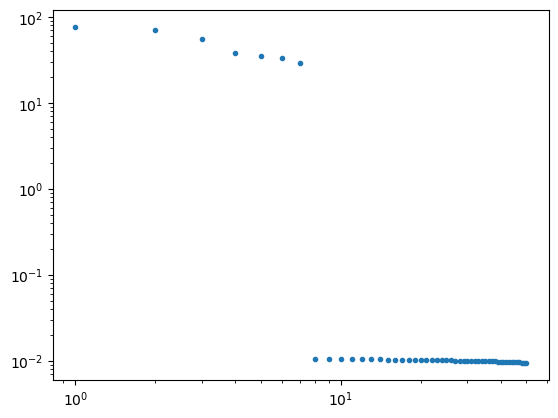

In [44]:
plt.plot(np.arange(1, N_CHANNELS+1), np.linalg.svd(np.cov(x_raw), compute_uv=False), '.')
plt.xscale('log')
plt.yscale('log')